This python notebook was prepared for the interview: <b> Data Scientist (KTP Associate) at Process Integration Ltd.</b>

The following task was requested:

<i> Please find attached a CSV file with readings from a flow meter in a large petrochemicals production plant. It is only one of many sensors that are available. The readings are taken once per minute. Flow meters tend to return quite noisy measurements and occasionally they return nonsensical values (outliers). We are interested in determining the steady states of operation, because ultimately we want to use these steady states to build a machine learning model of the plant using only sensor measurements. <p>

Please use Python to explore the data and produce a 10 minute presentation. Focus on one of the following data tasks: noise level estimation, smoothing, outlier detection, or steady state detection. Implement your method in Python and present your approach and findings to a mixed team of Chemical Engineers, Mathematicians, and Computer Scientists.</i>

This python code was prepared and executed on IBM Cloud, with embedded IBM Watson Studio (up to 4GB RAM memory).


### Why did I apply for this position? - My intentions and background
Hello,
My name is Kamil and I am a researcher-scientist with a background in Chemistry/Physical Chemistry and PhD in Chemical Engineering. And this is about me and why I am interested in the above position.

Knowledge Transfer Partnerships (KTP) is a great idea - it allows people like me to taste working in industry, and still being a part of academia, whilst evolving in both of these areas at the same time (also - as UoM staff you get access to so many databases!). It usually comes with a fund for the associate which can be used for training, conferences, <i> etc.</i> I, personally,  recently have been looking to more dynamic, product-oriented environment - such as those offered by industry, and needless to say a new challenge! Moreover, I am fascinated with the possibilities data science, or generally computer science, can offer us (even though I curse it everyday scrolling down my internet pages and having to look at all the <i>tailored</i> adverts!).<p>
One could say it all sounds great (and cliché). But what are my true intentions for applying for this position?<p>
    
I have been doing research for the last 6 or so (you really lose count after some time!) years. During my PhD I had the chance to work with Prof. Johan Jacquemin who is a specialist in equations of state, data analysis and modelling for chemistry/chemical engineering purposes. Thus, a natural course of progression was to do some modelling. Because my PhD was focused on thermophysical properties of ionic liquid - based nanofluids (basically a liquid mixed with nanoparticles), I did some predictive modelling of these thermophysical properties for pure ionic liquids (and some regression models for the mixtures). From the quantum chemical calculations, I have redefined the parameters of the most plausible model by adding charge distribution on the molecule parameters. I was able to reduce the error from 12.57% to 4.28% (average absolute relative deviation, which is really good in the prediction of thermophysical properties!). For the last year, I have been predicting mutual solubility of liquids, hydrogen bonding affinity. And whilst this was my day-to-day minor tasks, it did not satisfy my craving for data science so in my spare time I have been working on finding a correlation between coordination parameter and thermophysical properties of organic liquids through kNN (well, I have not discovered anything yet) in Python.<p>

I am an excellent researcher - which was highlighted by awarding me two prizes for contribution to thermal sciences. And while I am no mathematician nor computer scientist, I am highly motivated and intelligent scientist with willingness to learn more and more. This position will allow me to work in completely different and challenging environment (with mathematicians, computer scientists, industry) and a new subject that I am sure I will excel should I be given the opportunity.
    
### Theoretical background behind this task
    
The data tasks discussed herein is steady-state detection.
    
To make it clear from the start, as steady-state conditions, we mean: <i> statistical properties of a process generating data (i.e. time series) do not change as a function of time.</i> It is important to know whether the investigated time series is steady-state or not, due to implications in further modelling and analysis. Thus, detecting it in a chemical process and using for modelling.
    
Non-stationary time series can be divided into the following groups:
    1. Random walk: value at time t is equal to the value at t-1 and some stochastic (non-systematic) white noise et: <math>
	H(s) = ∫1^{0}<sup>∞</sup> e<sup>-st</sup> h(t) dt
</math>, with et of average equal to 0 and variance s2. The variance is time-dependent, increasing to infinity - thus, random walk cannot be predicted.
    2. Cycle
    3. Trend (+ Random walk/+Cycle) - 

In [3]:
# Reading all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import norm
from statsmodels.tsa.stattools import acf,pacf

# Importing data from GitHub
df=pd.read_csv('https://raw.githubusercontent.com/kamiloster/Data_Scientist_Interview/master/data.csv', header=None, names=['Flow'])

#--------------------------------
# Approach 1 - on the entire dataset
#--------------------------------

# Basic statistics
df.describe()

,Flow
count,131039.000000
mean,33.367791
std,2.913794
min,0.000000
25%,31.138000
50%,33.193000
75%,35.646000
max,56.223000


Generally, the data set is quite substantial - over 130k data points. 
The average value of the flow reading over the whole set is 33.4 with standard deviation of 2.9. 
Clearly, the data set contains outliers - minimum value of 0 and maximum of 56.22. 
Mean and median have similar values (33.4 and 33.2, respectively) indicating on the symmetrical distribution.

In [ ]:
# Histogram
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(df, bins=100)
axs[1].hist(df, bins=50)


plt.subplot(1, 2, 1)
ax1=df.hist(bins=100)
plt.title('Histogram of flow readings') # add a title to the histogram
plt.ylabel('Frequency') # add y-label
plt.xlabel('Flow reading values') # add x-label
plt.axvline(x=31, linewidth=1, color='r')
plt.axvline(x=33.6, linewidth=1, color='g')
plt.axvline(x=35.7, linewidth=1, color='b')

ax2=plt.subplot(222, frameon=False)

A quick look at the histagram can show that despite similar median and average values of the whole dataset, the histogram is barely symmetrical. Moreover, very qualitatively, there can distinguish three centres: </p>

(i) at flow meter reading 31 (red) </p>

(ii) at flow meter reading 33.8 (green) </p>

(iii) at flow meter reading 35.7 (blue)

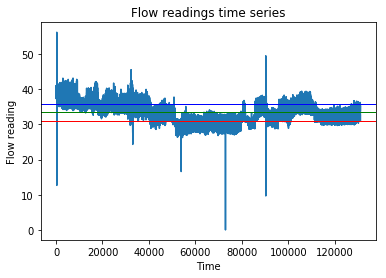

In [21]:
# Plotting flow meter reading(time)
plt.plot(df)
plt.xlabel('Time (min)')
plt.ylabel('Flow meter reading')
plt.title('Flow readings time series')
plt.ylabel('Flow reading')
plt.xlabel('Time')
plt.axhline(y=31, linewidth=1, color='r')
plt.axhline(y=33.6, linewidth=1, color='g')
plt.axhline(y=35.7, linewidth=1, color='b')

plt.show()

Plotting the graph of flow meter reading(time) shows some dependencies of the flow reading over time: </p>
    
(i) <50k minutes consistent decrease of flow reading values (a short period in the beginning, blue on the histogram); </p>

(ii) >50k & <80k visibly constant values (red on histogram); </p>

(iii) >80k & <110k consistent increase of flow reading values; </p>

(iv) >110k visibly constant values (green on histogram)

In [117]:
# Statistical test: Augmented Dickey-Fuller (adfuller) and Kwiatkowski-Phillips-Schmidt-Shin (KPSS)

X_adf = df.iloc[:,0].values
result_adf = adfuller(X_adf, regression='ct')
result_kpss=kpss(X_adf, regression='ct')

print('ADF Statistic: %f' % result_adf[0])
print('p-value: %f' % result_adf[1])
print('Critical Values:')
for key, value in result_adf[4].items():
	print('\t%s: %.3f' % (key, value))
    
print('KPS test statistics %f' %result_kpss[0])
print('p-value: %f' %result_kpss[1])
print('Truncation lag parameter: %f' %result_kpss[2])
print('Critical Values:')
for key, value in result_kpss[3].items():
	print('\t%s: %.4f' % (key, value))
    
print(f'Result of ADF test: The series is {"not " if result_adf[1] > 0.05 else ""}stationary')
print(f'Result of KPSS test: The series is {"not " if result_kpss[1] < 0.05 else ""}stationary')

ADF Statistic: -7.973630
p-value: 0.000000
Critical Values:
	1%: -3.959
	5%: -3.411
	10%: -3.127
KPS test statistics 26.427089
p-value: 0.010000
Truncation lag parameter: 73.000000
Critical Values:
	10%: 0.1190
	5%: 0.1460
	2.5%: 0.1760
	1%: 0.2160
Result of ADF test: The series is stationary
Result of KPSS test: The series is not stationary


/opt/conda/envs/Python36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


As can be seen, the statistical results produced contradictory results, i.e. ADF showed the time series is stationary, and KPSS that the time series is not stationary.